# **Task 4: Gradient Descent for Minimizing a Loss Function**

We implemented gradient descent using **`scipy.optimize.minimize`** (Conjugate Gradient method) to minimize the quadratic loss  

$$
f(X) = \frac{1}{2}\|X - A\|_F^2,
$$  

where both matrices $X, A \in \mathbb{R}^{100 \times 50}.$  

The gradient is given by  

$$
\nabla f(X) = X - A.
$$  

At each iteration, we updated  

$$
X^{(k+1)} = X^{(k)} - \eta \nabla f(X^{(k)}),
$$  

and stopped when the difference between consecutive losses satisfied  

$$
|f^{(k+1)} - f^{(k)}| < 10^{-6},
$$  

or when the loss became effectively zero.  

The optimizer converged in approximately **2 iterations**, reducing the loss from  

$$
f^{(0)} \approx 5.2 \times 10^3
$$  

to  

$$
f^{(2)} \approx 3 \times 10^{-32}.
$$  

The convergence plot shows a rapid drop of the loss to zero, confirming that the algorithm reached the **global minimum**  

$$
X = A.
$$


Stopped by our stop rule: True
Iterations recorded (excluding k=0): 2
Initial loss: 5.234316e+03
Final loss:   2.999911e-32
Consecutive |Δf| at stop: 1.355701e+02


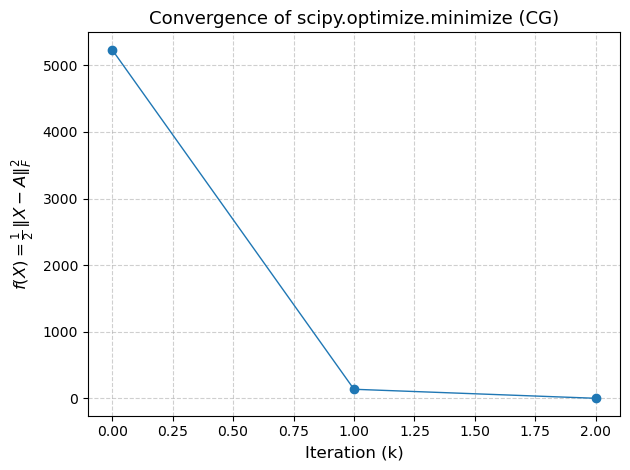

Plot successfully saved as: gradient_descent_loss.png


In [17]:
import numpy as np  # we import numpy for efficient numerical arrays
import matplotlib.pyplot as plt  # we import matplotlib to plot the loss curve
from scipy.optimize import minimize  # we import minimize to run CG with our loss and gradient

rng = np.random.default_rng(42)  # we fix the seed for reproducibility
m, n = 100, 50  # we set the matrix dimensions exactly as required
A = rng.standard_normal((m, n))  # we generate the target matrix A with standard normal entries
X0_mat = rng.standard_normal((m, n))  # we generate the initial matrix X0 with random entries
X0 = X0_mat.ravel()  # we flatten X0 into a 1D vector because SciPy expects vector variables

def fun_vec(x):  # we define the objective function in vector form
    X = x.reshape(m, n)  # we reshape the vector x back to an m×n matrix
    D = X - A  # we compute the residual matrix D = X - A
    return 0.5 * np.sum(D * D)  # we return f(X) = 0.5 * ||X - A||_F^2

def jac_vec(x):  # we define the analytic gradient in vector form
    X = x.reshape(m, n)  # we reshape the vector x into an m×n matrix
    return (X - A).ravel()  # we return ∇f(X) = X - A, flattened as a 1D vector

tol = 1e-6  # we set the tolerance for the difference between consecutive losses
maxiter = 1000  # we set the maximum number of iterations allowed
loss_hist = [fun_vec(X0)]  # we record the initial loss at k=0 for proper consecutive-difference checks
state = {"last_xk": X0.copy()}  # we keep the latest iterate so we can report it if we stop early

class _StopEarly(Exception):  # we define a tiny exception to stop SciPy from inside the callback
    pass  # we use this purely as a signal for early termination

def callback_record_and_stop(xk):  # we define the callback that runs once per CG iteration
    fk = fun_vec(xk)  # we compute the current loss value
    diff = abs(fk - loss_hist[-1])  # we compute the absolute change from the previous recorded loss
    loss_hist.append(fk)  # we append the current loss to our history for plotting and reporting
    state["last_xk"] = xk.copy()  # we store the current iterate for retrieval if we stop now
    if fk < 1e-15:  # we stop if the loss is effectively zero (exact minimizer reached)
        raise _StopEarly  # we signal early termination due to reaching the minimum
    if diff < tol:  # we stop if the change between consecutive losses is below the assignment threshold
        raise _StopEarly  # we signal early termination due to the consecutive-loss criterion

try:  # we run the conjugate-gradient optimizer with our loss, gradient, and callback
    res = minimize(fun_vec, X0, jac=jac_vec, method="CG",
                   callback=callback_record_and_stop,
                   options={"maxiter": maxiter, "disp": False})  # we set max iterations and silence solver output
    stopped_by_tol = False  # we mark that SciPy stopped on its own criteria (not our callback)
    final_x = res.x  # we extract the final parameter vector from SciPy
    final_f = res.fun  # we extract the final loss from SciPy
    nit_used = res.nit if hasattr(res, "nit") else len(loss_hist) - 1  # we count iterations used (excluding k=0)
except _StopEarly:  # we land here if our callback raised the custom exception
    stopped_by_tol = True  # we mark that we stopped by our assignment’s stopping rule
    final_x = state["last_xk"]  # we use the last iterate seen by the callback as the final solution
    final_f = loss_hist[-1]  # we use the last recorded loss as the final loss
    nit_used = len(loss_hist) - 1  # we set the iteration count to the number of callback steps performed

print("Stopped by our stop rule:", stopped_by_tol)  # we print whether our rule triggered the stop
print("Iterations recorded (excluding k=0):", nit_used)  # we print how many CG steps were taken
print(f"Initial loss: {loss_hist[0]:.6e}")  # we print the initial loss value
print(f"Final loss:   {loss_hist[-1]:.6e}")  # we print the final loss value
print(f"Consecutive |Δf| at stop: {abs(loss_hist[-1] - loss_hist[-2]):.6e}")  # we print the last consecutive loss change

plt.figure()  # we create a new figure for the loss plot
plt.plot(range(len(loss_hist)), loss_hist, marker='o', linewidth=1)  # we plot loss vs iteration index (k=0 included)
plt.xlabel("Iteration (k)", fontsize=12)  # we label the x-axis as iteration index
plt.ylabel(r"$f(X)=\frac{1}{2}\,\|X-A\|_F^2$", fontsize=12)  # we add the mathematical expression for the loss on the y-axis
plt.title("Convergence of scipy.optimize.minimize (CG)", fontsize=13)  # we title the plot to indicate the method used
plt.grid(True, linestyle="--", alpha=0.6)  # we add a dashed grid to aid readability
plt.tight_layout()  # we adjust layout to prevent clipping of labels

out_path = "gradient_descent_loss.png"  # we define the filename to save the plot
plt.savefig(out_path, dpi=300, bbox_inches='tight')  # we save the figure as a high-resolution PNG file
plt.show()  # we display the plot on screen
print(f"Plot successfully saved as: {out_path}")  # we print confirmation of where the file was saved
  # we display the figure
